In [39]:
import numpy as np
import torch 
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])

# 数据集载入
train_data = datasets.MNIST(root = "./data/",transform=transform,train = True,download = True)
test_data = datasets.MNIST(root="./data/",transform = transform,train = False)
print('训练集/测试集:',len(train_data),'/',len(test_data))

#加载器
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True,num_workers=2)
print('训练batch/测试batch:',len(train_loader),'/',len(test_loader))


训练集/测试集: 60000 / 10000
训练batch/测试batch: 938 / 157


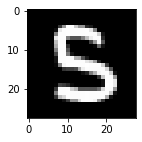

tensor(5)


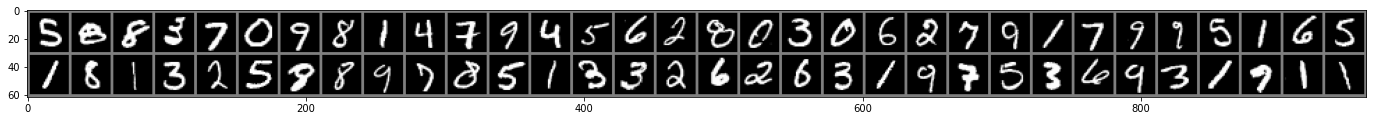

5 8 8 3 7 0 9 8 1 4 7 9 4 5 6 2 8 0 3 0 6 2 7 9 1 7 9 9 5 1 6 5 
1 8 1 3 2 5 8 8 9 7 8 5 1 3 3 2 6 2 6 3 1 9 7 5 3 6 9 3 1 9 1 1 


In [40]:
data_iter = iter(train_loader)
nd = next(data_iter)
oneimg,label = nd[0][0],nd[1][0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.figure(figsize=(2,2))
plt.imshow(grid)
plt.show()
print(label)

images, lables =nd
plt.figure(figsize=(24,12))
img = utils.make_grid(images,32)
# transpose 转置函数(x=0,y=1,z=2),新的x是原来的y轴大小，新的y是原来的z轴大小，新的z是原来的x大小
#相当于把x=1这个一道最后面去。
img = img.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
img = img * std + mean
plt.imshow(img)
plt.show()
for i in range(64):
    print(int(lables[i]), end=" ")
    i += 1
    if i%32 == 0:
        print(end='\n')

In [63]:
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fh0 = nn.Linear(64*7*7,1024*3)#两个池化，所以是7*7而不是14*14
        self.fh1 = nn.Linear(1024*3,1024)
        self.fh2 = nn.Linear(1024,256)
        
        self.fo = nn.Linear(256,10)
#         self.dp = nn.Dropout(p=0.5)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的 
        x = F.relu(self.fh0(x))
        x = F.relu(self.fh1(x))
        x = F.relu(self.fh2(x))   
        x = self.fo(x)  
#         x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x
net = CNN()


c:\python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


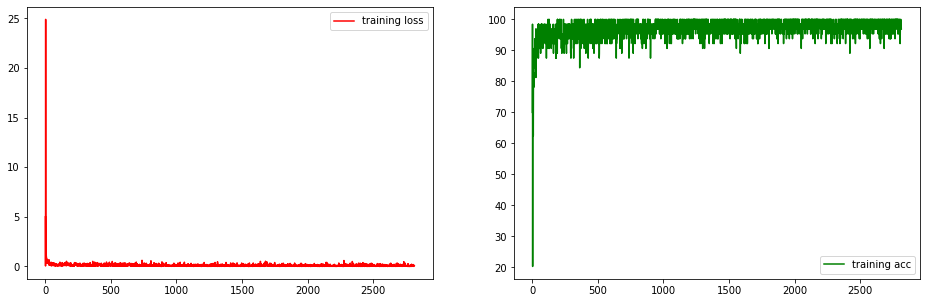

In [67]:
import datetime as dt
import tqdm.notebook as tqnb
tstart=dt.datetime.now()
train_accs = [70]
train_loss = [5]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adagrad(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(net.parameters(),lr=0.005)#Adam优化方法比较时髦

roundx=3
pbar = tqnb.tqdm(total=len(train_loader)*roundx)
for epoch in range(roundx):
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0是下标起始位置默认为0
        # data 的格式[[inputs, labels]]       
#         inputs,labels = data
        inputs,labels = data[0].to(device), data[1].to(device)
        #初始为0，清除上个batch的梯度信息
        optimizer.zero_grad()         

        #前向+后向+优化     
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # loss 的输出，每个一百个batch输出，平均的loss
        running_loss += loss.item()
#         if i%100 == 99:
#             print('%d,%d-%.3f' % (epoch+1,i+1,running_loss/100), end='|')
#             running_loss = 0.0
        train_loss.append(loss.item())

        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)
        pbar.update(1)
pbar.close()
torch.cuda.empty_cache()
dt.datetime.now()-tstart

import seaborn as sns
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    fig, axes = plt.subplots(1, 2, figsize=[16, 5])
    sns.lineplot(iters, costs,color='red',label=label_cost, ax = axes[0]) 
    sns.lineplot(iters, accs,color='green',label=lable_acc,ax=axes[1]) 
    plt.show()
train_iters = range(len(train_accs))
draw_train_process('training',train_iters,train_loss,train_accs,'training loss','training acc')


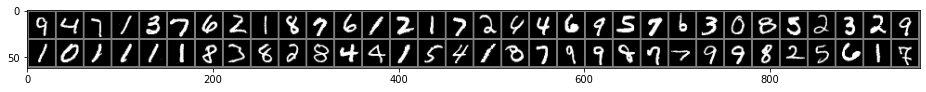

R:  9 4 7 1 3 7 6 2 1 8 7 6 1 2 1 7 2 4 4 6 9 5 7 6 3 0 8 5 2 3 2 9 1 0 1 1 1 1 8 3 8 2 8 4 4 1 5 4 1 8 7 9 9 8 7 7 9 9 8 2 5 6 1 7
G:  9 4 7 1 3 7 6 2 1 8 7 6 1 2 1 7 2 4 4 6 9 5 7 6 3 0 8 5 2 3 2 9 1 0 1 1 1 1 8 3 8 2 8 4 4 1 5 4 1 8 7 9 9 4 7 7 9 9 8 2 5 6 1 7
-:  _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ | _ _ _ _ _ _ _ _ _ _



算法评价:
              precision    recall  f1-score   support

           0    0.99692   0.99184   0.99437       980
           1    0.99821   0.98502   0.99157      1135
           2    0.98346   0.97965   0.98155      1032
           3    0.97758   0.99307   0.98527      1010
           4    0.99473   0.96130   0.97773       982
           5    0.97553   0.98318   0.97934       892
           6    0.97835   0.99061   0.98444       958
           7    0.96762   0.98833   0.97786      1028
           8    0.98636   0.96509   0.97561       974
           9    0.96408   0.98414   0.97401      1009


In [68]:
dataiter = iter(test_loader)
images,labels = dataiter.next()

plt.figure(figsize=(16,4))
test_img = utils.make_grid(images,32)
test_img = test_img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean =  [0.5,0.5,0.5]
test_img = test_img*std+0.5
plt.imshow(test_img)
plt.show()

print('R: ', ' '.join('%d' % labels[j] for j in range(64)))
test_out = net(images.to(device))
predicted = torch.max(test_out, dim=1)[1]
print('G: ', ' '.join('%d' % predicted[j] for j in range(64)))
x=  predicted.cpu()-labels
print('-: ',' '.join('%c'%('_' if i==0 else '|') for i in x ))


from sklearn.metrics import classification_report
test_loader_all = torch.utils.data.DataLoader(test_data,shuffle=True,num_workers=2,batch_size=len(test_data))
dataiter = iter(test_loader_all)
images,labels = dataiter.next()
test_out = net(images.to(device))
predicted = torch.max(test_out, dim=1)[1]
print('\n\n\n算法评价:')
print(classification_report(labels, predicted,digits=5))



In [69]:
torch.save(net.state_dict(), "./ai_1222_1624")